In [ ]:
# for colab
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
project_dir = '/content/gdrive/My Drive/ColabNotebooks/AI'
import sys
sys.path.insert(0, project_dir)

# Step by step mcts

In [4]:
from models import Model, Trainer
from env_test import Env
from mcts import MCTS

class dotdict(dict):
    def __getattr__(self, name):
        return self[name]

model =Model()# LSTMTagger()#Model()
env = Env(1,1)

args = dotdict({'cpuct':0.5, 'iters':2000})

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:

mcts2 = MCTS(env, model, args)
val = list(mcts2.sampling())
print(len(val))
#val = [v for v in val if v.parent and v.parent.times_visited > 2]
#print(len(val))
t = Trainer(env, batch_size=50)
#t.train_model(val, model, batch_size=10, net_iters=300)
#examples = deque([], maxlen=1000)

batch = t.get_batch(val, batch_size=5)
#for b in t.transform_bach_as_input(batch):
#    print(b)
#import matplotlib.pyplot as plt

#plt.plot(t.loss_backet)
#plt.show()

3152


In [8]:
from sklearn.model_selection import train_test_split


train = {'1o1':[], '1o2':[], '1o3':[]}
test = {'1o1':[], '1o2':[], '1o3':[]}
for k in train:
    env = Env(1,int(k[2]))
    mcts2 = MCTS(env, model, args)
    X = list(mcts2.sampling())
    val = t.clean_unpredict_node(X)
    y = t.transform_bach_as_input(val, model)
    print(len(X), len(y), len(val))
    y_train_ind, y_test_ind = train_test_split(range(len(y[0])))
    for i in range(3):
        train[k].append(y[i][y_train_ind])
        test[k].append(y[i][y_test_ind])

3180 3 2584
1iCA 1iCAA 0
1iCAA 1iCAAB 0
1iCAAB 1iCAAB1 0
1iCAAB1 1iCAAB1A 0
1iCAAB1A 1iCAAB1AB 0
3872 3 3164
CAAC CAAC1 0
CAAC1 CAAC1s 0
CAAC1s CAAC1se 0
3822 3 3017


In [43]:
#print([(v.formula, v.history_data['time']) for v in val if 'ie' in v.formula])
k = '1o2'
X = train[k][0]#[:10]
y = train[k][1]#[:10]

In [45]:
Xt = test[k][0]
yt = test[k][1]

In [11]:
def loss_rew(tr, pr):
    return np.sum((tr - pr)**2)

In [32]:
import numpy as np
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
loss_rew(yt, reg.predict(Xt))

378.13991316180477

In [46]:
loss_rew(yt, model.predict(Xt)[1])

366.1409428233979

In [42]:
loss_rew(yt, np.mean(y))

385.5460235432056

In [20]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=300)#, criterion='mae')
regr.fit(X, y)

/home/denis/anaconda3/envs/tourch_gym/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [21]:
loss_rew(yt, regr.predict(Xt))

273381.1193101935

In [199]:
#regr.predict(test['1o1'][0])
#test['1o1'][1]

In [200]:
from sklearn.linear_model import BayesianRidge
clf = BayesianRidge()
clf.fit(X, y)

/home/denis/anaconda3/envs/tourch_gym/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [201]:
loss_rew(yt, clf.predict(Xt))

341474.09408862854

In [18]:
from sklearn.neighbors import KNeighborsRegressor
clf = KNeighborsRegressor()
clf.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [19]:
loss_rew(yt, clf.predict(Xt))

556.271341391104

In [33]:
import torch
from torch import Tensor, nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cnv1 = nn.Conv1d(1,6,8)
        self.fc1 = nn.Linear(18, 64)
        self.fc2 = nn.Linear(64, 64)
        self.action_prob_out = nn.Linear(64, 8)
        #self.val0 = nn.Linear(40, 80)
        self.val = nn.Linear(64, 1)

    def forward(self, x):
        #print(x.shape)
        #x = x.view(-1,17)
        #x = self.cnv1(x.view(1, 1,-1))
        # print(x.shape)
        #x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        act_prob = F.softmax(self.action_prob_out(x), dim=-1)
        val = F.tanh(self.val(x))
        #val_sum = self.val_sum_out(val)

        return act_prob, val

    def predict(self, x):
        self.eval()
        #x = Variable(Tensor(x))
        act_prob, val = self.forward(x)
        return act_prob.data.numpy(), val.data.numpy()


def get_batch(nodes_buc, batch_size=20):
    """remove all nodes that have not history"""
    n = len(nodes_buc)
    index = [
        np.random.randint(0, n - 1)
        for _ in range(batch_size)
    ]
    #print(len(self.replay), index, [self.replay[i] for i in index]   )
    return index#[nodes_buc[i] for i in index]


def train_model(Xa,yr,yp, model, batch_size=10, net_iters=200):
    optimizer = optim.SGD(model.parameters(), lr=0.1)#, momentum=0.03, weight_decay=0.1)
    loss_backet = []
    for i in range(net_iters):
        #batch = #self.get_batch(nodes_buc, batch_size=batch_size or self.batch_size)
        # print(batch)
        ind = get_batch(Xa)

        X, real_reward, real_prob = Xa[ind], yr[ind], yp[ind]#self.transform_bach_as_input(batch, model)


        #print(i, real_prob.shape)
        model.train()
        #for x, rr, rp in zip(X, real_reward, real_prob):
            #print(xx, rrr,rpp)
        optimizer.zero_grad()
        #print(X)
        p_pred, v_pred = model(X)
        # print('pr  ', probability, 'pp  ', p_pred)
        val_loss = torch.mean((Variable(Tensor(real_reward)) - v_pred) ** 2)  # , Variable(Tensor([10]))
        loss = val_loss - torch.mean(Variable(Tensor(real_prob)) * torch.log(p_pred))
        #loss = - torch.mean(Variable(Tensor(real_prob)) * torch.log(p_pred))
        #print(loss, rpp, p_pred)
        loss.backward()
        optimizer.step()
        loss_backet.append(loss.data.numpy())
        
    return loss_backet

model = Model()

/home/denis/anaconda3/envs/tourch_gym/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


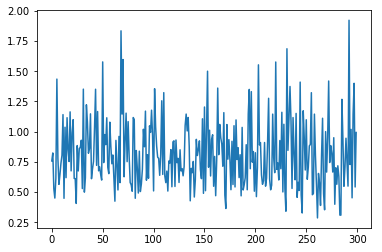

In [34]:
lossb = train_model(X, y, train[k][2], model, net_iters=300)
plt.plot(lossb)
plt.show()

# Embeding actions

In [ ]:
import numpy as np
from collections import defaultdict
treegramm_count = defaultdict(lambda: defaultdict(int))

treegramm_count

def delta(dict1, dict2):
    #print(np.sum(list(dict1.values()), dict1.values())
    return np.sum(list(dict1.values())) - np.sum(list(dict2.values()))

def betreegrams(val, env, treegramm_count):
    results = {}
    treegramm_count = defaultdict(lambda: defaultdict(int))
    for v in val[:100]:
        #print(env.result, v.formula)
        env.calc_formula(v.formula)
        results[v.formula] = env.result.copy()
        if env.result['o'] == env.out: print(v.formula)
    #print(results)
    for v in val[:100]:
        # beegram
        for i in range(len(v.formula)-2):
            # beegram
            #print(i, results[v.formula[:i]], v.formula[:i])
            if i > 0 and delta(results[v.formula[:i]], results[v.formula[:i + 1]]) != 0:
                
                treegramm_count[v.formula[i-1]][v.formula[i]] += 1
                treegramm_count[v.formula[i-1:i+1]][v.formula[i+1]] += 1
            if i > 0 and delta(results[v.formula[:i]], results[v.formula[:i + 2]]) != 0:
                # ?? peace of sheet!! eB1 in 1ABCieB1e we could remove it...
                #print('aa', v.formula, v.formula[:i+1], results[v.formula[:i]], results[v.formula[:i+2]],
                #      v.formula[i-1], v.formula[i-1:i+2]
                #     )
                treegramm_count[v.formula[i-1]][v.formula[i]] += 1
                treegramm_count[v.formula[i-1:i+1]][v.formula[i+1]] += 1
        i = len(v.formula) - 1
        if i >= 0 and delta(results[v.formula[:i]], results[v.formula[:i + 1]]) != 0:
            treegramm_count[v.formula[i-1]][v.formula[i]] += 1
    return treegramm_count, results
    
            
t, r = betreegrams(val, env, treegramm_count)                

In [ ]:
t

In [ ]:
def count_grams(val, env, treegramm_count):
    results = {}
    treegramm_count = defaultdict(lambda: defaultdict(int))
    treegramm_list = []
    for v in val:
        #print(env.result, v.formula)
        env.calc_formula(v.formula)
        results[v.formula] = env.result.copy()
        if env.result['o'] == env.out: print(v.formula)
    #print(results)
    for v in val:
        # beegram
        for i in range(len(v.formula)-2):
            if i>0 and delta(results[v.formula[:i+1]], results[v.formula[:i+2]]):
                #print(v.formula)
                #treegramm_count[v.formula[i:i+1]][v.formula[i+1:i+2]] += 1
                treegramm_count[v.formula[i-1:i+1]][v.formula[i+1:i+2]] += 1
                #treegramm_list.append([list(v.formula[i-1:i+1]), v.formula[i+1:i+2]])
                treegramm_list.append([list(v.formula[i-1:i]), v.formula[i:i+1]])
                treegramm_list.append([list(v.formula[i:i+1]), v.formula[i+1:i+2]])
            # beegram
            
        #i = len(v.formula) - 1
        #if i >= 0 and delta(results[v.formula[:i]], results[v.formula[:i + 1]]) != 0:
            #treegramm_count[v.formula[i-1]][v.formula[i]] += 1
    return treegramm_count, treegramm_list, results

t, tl, r = count_grams(val, env, treegramm_count)   
#tl

In [ ]:
len(tl)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
CONTEXT_SIZE = 1
EMBEDDING_DIM = 10
trigrams = tl#[([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
           # for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])

vocab = set(env.action_space)
word_to_ix = {word: i for i, word in enumerate(env.action_space)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

In [ ]:
dataframe = np.vstack([model.embeddings(torch.tensor([i])).data.numpy() for i in range(8)])

In [ ]:
from sklearn.decomposition import PCA


#dataframe = np.concatenate([samples, test], axis=0)#[train, test, samples], axis=0)

pca = PCA(n_components=2)
X_feature_reduced = pca.fit(dataframe).transform(dataframe)
# map word vectors onto 2d plane with PCA. Use good old sklearn api (fit, transform)
# after that, normalize vectors to make sure they have zero mean and unit variance
#word_vectors_pca = # YOUR CODE

# and maybe MORE OF YOUR CODE here :)

In [ ]:
plt.scatter(x=X_feature_reduced[:,0], y=X_feature_reduced[:,1])

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [ ]:
draw_vectors(X_feature_reduced[:, 0], X_feature_reduced[:, 1], token=list(vocab))

In [ ]:
class def_zer():
    def __init__(self):
        return np.zeros([8])


In [ ]:
from collections import defaultdict
j= defaultdict(int)
prj = np.zeros([8])

In [ ]:
model = sm

In [ ]:
clval = t.clean_unpredict_node(val)
sm.train(clval)
for f in clval:
    last = -1
    if f.formula and f.formula[-1:]=='e' and len(f.history_data['next_node_ind']) > last:
        print(f.times_visited, f.formula, f.history_data['next_node_ind'][last])                                       
        j[f.history_data['next_node_ind'][last]] += 1
        x = model.get_observation(f.formula, env)
        prj += model.predict(x)[0].reshape([8])
        

#[(f.formula, f.history_data['next_node_ind'][0], j[f.history_data['next_node_ind'][0]] += 1) 

In [ ]:
j

In [ ]:
prj

In [ ]:
prj

In [ ]:
[f.formula for f in val]

# LSTM Model

In [ ]:
import numpy as np
from LSTMmodel import LSTMModel, mctsTrainer
#import torch
#from torch import Tensor, nn
#import torch.optim as optim
#from torch.autograd import Variable
#import torch.nn.functional as F
from env_test import Env
from mcts import MCTS

class dotdict(dict):
    def __getattr__(self, name):
        return self[name]

model = LSTMModel(4, 32, 8, 8)

env = Env()
stm = StModel(env)

args = dotdict({'cpuct':0.5, 'iters':1000})
mcts = MCTS(env, stm, args)
#val = list(mcts2.sampling())
val = t.clean_unpredict_node(val)
print(len(val))
val = [v for v in val if v.parent and v.parent.times_visited > 2]
print(len(val))


t = mctsTrainer(env, mcts, batch_size=10)

#t = Trainer(env, batch_size=20)
for i in range(3):
    print(i, t.loss_backet[-3:])
    mcts = MCTS(env, stm, args)
    
    #print(len(val), val[-1].history_data['time'], val[-1].formula) 
    
    #print('aa', val)
    #t.train_model(val, model, net_iters=300)
    val = list(mcts2.sampling())
    val = t.clean_unpredict_node(val)
# #examples = deque([], maxlen=1000)
#
#batch = t.get_batch(val)
#print(list(t.transform_bach_as_input(batch)[1]))

import matplotlib.pyplot as plt
#
plt.plot(t.loss_backet)
plt.show()

In [ ]:
#torch.zeros(25) + 8
env.action_space.index('o')

# Stat model

In [48]:
from collections import defaultdict

class StModel:
    def __init__(self, env):
        self.env = env
        self.stat = np.random.rand(8, 8)
        self.vstat = np.random.rand(8)
        
    def train(self, val):
        self.stat = np.zeros([8, 8])
        self.predvst = defaultdict(list)
        self.vstat = np.zeros([8])
        for node in val:
            if node.formula:
                v = self.env.action_space.index(node.formula[0])
                nv = node.history_data['next_node_ind'][-1]
                nr = node.history_data['next_node_val'][-1]
                self.stat[v][nv] += 1
                self.predvst[v].append(nr)
        self.stat /= np.sum(self.stat, axis=0) + 0.0001
        for i, k in enumerate(self.predvst):
            self.vstat[i] = sum(self.predvst[k]) / len(self.predvst[k])
         
            
    def predict(self, formula):
        v = self.env.action_space.index(formula[-1])
        return self.stat[:, v], self.vstat[v]
    
    def get_observation(self, formula, env, time=0):
        return formula
            
sm = StModel(env)
sm.train(val)
sm.predict('Ai')

(array([0.12437805, 0.13432829, 0.        , 0.17412927, 0.15422878,
        0.1592039 , 0.15422878, 0.09950244]), 0.1713745847757056)

# Train LSTM

In [ ]:
t = mctsTrainer(env, mcts, batch_size=20)

def get_sorted_batch(val, batch_size=20):
    sort_val = sorted(val, key=lambda x: len(x.formula))
    i = np.random.randint(len(val) - batch_size)
    yield sort_val[i:i + batch_size]
    


In [ ]:
#sbach = list(get_sorted_batch(val))
#print(sbach[0])
#for i in sbach[0]: 
#    print(i.formula)

In [ ]:
for epoch in range(10):
    batch = list(get_sorted_batch(val))
    
    torch.cat([model.get_observation(n.formula, env) for n in batch]).view(t.batch_size)

In [ ]:
CONTEXT_SIZE = 1
EMBEDDING_DIM = 10
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])

vocab = set(env.action_space)
word_to_ix = {word: i for i, word in enumerate(env.action_space)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

In [ ]:
from random import shuffle

In [ ]:
def val_data(val):
    print(val.formula, val.fin_prob, val.ucb_score())

shuffle(val)
for i in range(30):
    val_data(val[i+1])

In [ ]:
mcts.Nodes['i1iBo'].times_visited

In [ ]:
t.transform_bach_as_input(t.get_batch(val))

In [ ]:
import pandas as pd

In [ ]:
values = {'1': 1, 'i': 0, 'o': 0, 'A': 0, 'B': 0, 'C': 0}
keys=list(values) + ['s', 'e']

dd = {'formula':[], 'val_sum':[]}
for i in replay_buffer.replay:
    dd['formula'].append(i[2])
    dd['val_sum'].append(i[3].value_sum)
    
    for j, k in enumerate(keys):
        #print('j', j, i[4])
        #print(i, i[4][j])
        dd[k] = i[4][j]

df = pd.DataFrame(dd)

In [ ]:
df[df['formula']=='']#['ucb'].idxmax()

In [ ]:
df[df['formula']=='ie']#['ucb'].idxmax()

In [ ]:
replay_buffer.get_batch()

In [ ]:
import torch.nn.functional as F
from torch import Tensor
F.softmax(Tensor([0,0,0])).numpy()

In [ ]:
test_env.reset()
Vocab, Vocab[1]

In [ ]:
j.select_best_leaf().action

In [ ]:
j.select_best_leaf().rollout(env, 10)

In [ ]:
test_env.step(1)

In [ ]:
test_env.step(3)

In [ ]:
test_env.step(1)

In [ ]:
test_env.step(2)

In [ ]:
test_env.step(1)

In [ ]:
test_env.step(3)

# Imetation learning 
### if we already know answer we should show it to mcts tree.

In [ ]:
#text = "input_eq_A A[2]_eq_out"
def text_to_actions(text, vocab=Vocab):
    action_seq = []
    i = 0
    operator = ''
    while i < len(text):
        if text[i] in Vocab:
            action_seq.append(Vocab.index(text[i]))
        else:
            operator += text[i]
            #print('ss', text[i], operator)
            if operator == 'input':
                operator = ''
                
            if operator in Vocab:
                action_seq.append(Vocab.index(operator))
                operator = ''


        i += 1
    return action_seq

for i in text_to_actions(text):
    print(Vocab[i])
text_to_actions(text)
        #print(Vocab.index(i))
        #print(env.step(1))
        #print(env.step(Vocab.index(i)))

In [ ]:
env.reset()

In [ ]:
#text = "input_sum_A" 
for i in text_to_actions(text):
    print(i)
    print(Vocab[i])
    print(env.step(i))

In [ ]:
text = "input_eq_A A[2]_const_AA AA_eq_out" 
c = CalcNode(text)
c.calc(1)

In [ ]:
import importlib
#import mcts
importlib.reload(mcts)

In [ ]:
root_observation = env.reset()
root_snapshot = env.get_snapshot()
root = mcts.Root(root_snapshot,root_observation)

#plan_mcts(root, env, n_iters=10000, t_max=20)

In [ ]:
root.is_leaf()

In [ ]:
while True:
    is_done = env.step(env.action_space.sample())[2]
    if is_done: 
        print("Whoops! We died!")
        break
        
print("final state:")
plt.imshow(env.render('rgb_array'))
plt.show()


In [ ]:
def teach_mcts(root, env, action_seq):
    """
    builds tree with monte-carlo tree search for n_iters iterations
    :param root: tree node to plan from
    :param n_iters: how many select-expand-simulate-propagete loops to make
    """
    #node = root
    #node = mcts.Node(root, action_seq[0], env)
    #root.children.add(node)
    for action in action_seq:
        #print(action)
        #print(node.is_done)
        
        #next_node = mcts.Node(next_node, action, env)
        #node.children.add(mcts.Node(node, action, env))
        #node = next_node
        
        #print(node.is_done)
        node = root.select_best_leaf()
        
        #print(Vocab[node.action])
        
        if node.is_done:
            if node.immediate_reward > 0:
                print("get_reward mcts plan!", node.immediate_reward)  
            
            node.propagate(0)
            #env.reset()
       
        else: #node is not terminal
            
            #print(_)
            #env.reset()
            #self.env.close()
            #self.render()
            node.expand(env)
            #print(Vocab[node.action])
            for i in node.children:
                print('dd', )#Vocab[node.action], node.parent.action)
            ## value = node.rollout(env, 10)
            #if value >0:
            #    print('plan after rolout', value, node.action)
            ##node.propagate(value)

In [ ]:
teach_mcts(root, env, text_to_actions(text))

In [ ]:
p = mcts.Node(root, 2, env)
#p.is_leaf()

In [ ]:
mcts.plan_mcts(root,env)

In [ ]:
for i in root.children:
    print(Vocab[i.action], i.value_sum, len(i.children))

In [ ]:
j = root
while j.children:
    j = j.children.pop()
    print(j.action, len(j.children))